# Enumerating Active Directory ->AD


Once we have that first set of AD credentials and the means to authenticate with them on the network, a whole new world of possibilities opens up! We can start enumerating various details about the AD setup and structure with authenticated access, even super low-privileged access.

During a red team engagement, this will usually lead to us being able to perform some form of privilege escalation or lateral movement to gain additional access until we have sufficient privileges to execute and reach our goals. In most cases, enumeration and exploitation are heavily entwined. Once an attack path shown by the enumeration phase has been exploited, enumeration is again performed from this new privileged position, as shown in the diagram below.
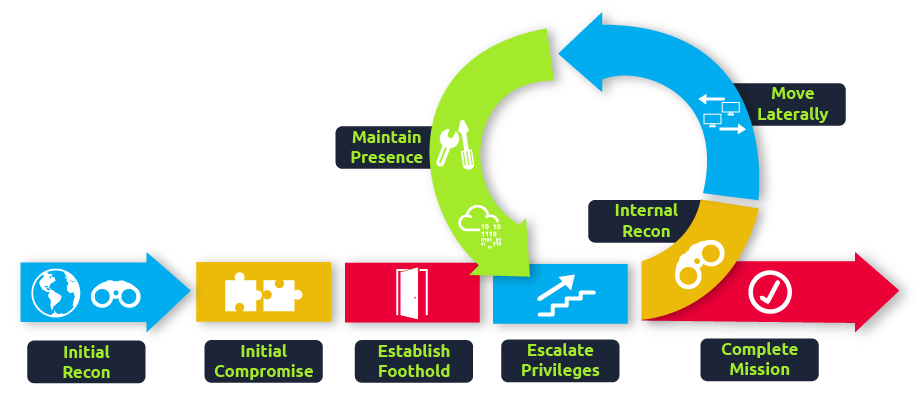

You know the drill. 
You will have to configure DNS on the host on which you are running the VPN connection. In order to configure our DNS, run the following command:

`systemd-resolve --interface enumad --set-dns 10.200.58.101 --set-domain za.tryhackme.com`

You can test that DNS is working by running:
`nslookup thmdc.za.tryhackme.com`

To simulate an AD breach, you will be provided with your first set of AD credentials. Once your networking setup has been completed, on your Attack Box, navigate to http://distributor.za.tryhackme.com/creds to request your credential pair. Click the "Get Credentials" button to receive your credential pair that can be used for initial access.

> Your credentials have been generated: Username: kathryn.dickinson Password: Catherin2018

This credential pair will provide you RDP and SSH access to THMJMP1.za.tryhackme.com. THMJMP1 can be seen as a jump host into this environment, simulating a foothold that you have achieved. Jump hosts are often targeted by the red team since they provide access to a new network segment. You can use Remmina or any other similar Remote Desktop client to connect to this host for RDP. Remember to specify the domain of za.tryhackme.com when connecting. Task 2 and 3 will require RDP access.

For SSH access, you can use the following SSH command:

`ssh za.tryhackme.com\\kathryn.dickinson@thmjmp1.za.tryhackme.com`

When prompted, provide your account's associated password. Although RDP can be used for all tasks, SSH is faster and can be used for Other Tasks(4 - 6.)


# Task 2 Credential Injection


You can get incredibly far doing AD enumeration from a Kali machine. Still, if you genuinely want to do in-depth enumeration and even exploitation, you need to understand and mimic your enemy. Thus, you need a Windows machine. This will allow us to use several built-in methods to stage our enumeration and exploits. In this network, we will explore one of these built-in tools, called the `runas.exe` binary.

- Runas Explained

Have you ever found AD credentials but nowhere to log in with them? Runas may be the answer you've been looking for!

In security assessments, you will often have network access and have just discovered AD credentials but have no means or privileges to create a new domain-joined machine. So we need the ability to use those credentials on a Windows machine we control.

If we have the AD credentials in the format of <username>:<password>, we can use Runas, a legitimate Windows binary, to inject the credentials into memory. The usual Runas command would look something like this:

`runas.exe /netonly /user:<domain>\<username> cmd.exe`

Let's look at the parameters:

- /netonly - Since we are not domain-joined, we want to load the credentials for network authentication but not authenticate against a domain controller. So commands executed locally on the computer will run in the context of your standard Windows account, but any network connections will occur using the account specified here.
- /user - Here, we provide the details of the domain and the username. It is always a safe bet to use the Fully Qualified Domain Name (FQDN) instead of just the NetBIOS name of the domain since this will help with resolution.
- cmd.exe - This is the program we want to execute once the credentials are injected. This can be changed to anything, but the safest bet is cmd.exe since you can then use that to launch whatever you want, with the credentials injected.


Once you run this command, you will be prompted to supply a password. Note that since we added the /netonly parameter, the credentials will not be verified directly by a domain controller so that it will accept any password. We still need to confirm that the network credentials are loaded successfully and correctly.

Note: If you use your own Windows machine, you should make sure that you run your first Command Prompt as Administrator. This will inject an Administrator token into CMD. If you run tools that require local Administrative privileges from your Runas spawned CMD, the token will already be available. This does not give you administrative privileges on the network, but will ensure that any local commands you execute, will execute with administrative privileges.

- It's Always DNS

Note: These next steps you only need to perform if you use your own Windows machine for the exercise. However, it is good knowledge to learn how to perform since it may be helpful on red team exercises.

After providing the password, a new command prompt window will open. Now we still need to verify that our credentials are working. The most surefire way to do this is to list SYSVOL. Any AD account, no matter how low-privileged, can read the contents of the SYSVOL directory.

SYSVOL is a folder that exists on all domain controllers. It is a shared folder storing the Group Policy Objects (GPOs) and information along with any other domain related scripts. It is an essential component for Active Directory since it delivers these GPOs to all computers on the domain

Before we can list SYSVOL, we need to configure our DNS. Sometimes you are lucky, and internal DNS will be configured for you automatically through DHCP or the VPN connection, but not always (like this TryHackMe network). It is good to understand how to do it manually. Your safest bet for a DNS server is usually a domain controller. Using the IP of the domain controller, we can execute the following commands in a PowerShell window:
```
$dnsip = "<DC IP>"
$index = Get-NetAdapter -Name 'Ethernet' | Select-Object -ExpandProperty 'ifIndex'
Set-DnsClientServerAddress -InterfaceIndex $index -ServerAddresses $dnsip
```

Of course, 'Ethernet' will be whatever interface is connected to the TryHackMe network. We can verify that DNS is working by running the following:

Command Prompt
`C:\> nslookup za.tryhackme.com`
Which should now resolve to the DC IP since this is where the FQDN is being hosted. Now that DNS is working, we can finally test our credentials. We can use the following command to force a network-based listing of the SYSVOL directory:

Command Prompt
`C:\Tools>dir \\za.tryhackme.com\SYSVOL\`

- IP vs Hostnames

Question: Is there a difference between `dir \\za.tryhackme.com\SYSVOL` and `dir \\<DC IP>\SYSVOL` and why the big fuss about DNS?

There is quite a difference, and it boils down to the authentication method being used. When we provide the *hostname*, network authentication will attempt first to perform *Kerberos authentication*. Since Kerberos authentication uses hostnames embedded in the tickets, if we provide the *IP* instead, we can force the authentication type to be *NTLM*. While on the surface, this does not matter to us right now, it is good to understand these slight differences since they can allow you to remain more stealthy during a Red team assessment. In some instances, organisations will be monitoring for OverPass- and Pass-The-Hash Attacks. Forcing NTLM authentication is a good trick to have in the book to avoid detection in these cases.

- Using Injected Credentials

Now that we have injected our AD credentials into memory, this is where the fun begins. With the /netonly option, all network communication will use these injected credentials for authentication. This includes all network communications of applications executed from that command prompt window.

This is where it becomes potent. Have you ever had a case where an MS SQL database used Windows Authentication, and you were not domain-joined? 
Start MS SQL Studio from that command prompt; even though it shows your local username, click Log In, and it will use the AD credentials in the background to authenticate!
We can even use this to authenticate to web applications that use NTLM Authentication.

We will be using that in the next task for our first AD enumeration technique.






# Task 3 Enumerating via Microsoft Management Console

#### Microsoft Management Console

In this task, we will explore our first enumeration method, which is the only method that makes use of a GUI until the very last task. We will be using the Microsoft Management Console (MMC) with the Remote Server Administration Tools' (RSAT) AD Snap-Ins.

This is where the Runas window from the previous task comes into play. In that window, we can start MMC, which will ensure that all MMC network connections will use our injected AD credentials.

In MMC, we can now attach the AD RSAT Snap-In:

- Click File -> Add/Remove Snap-in
- Select and Add all three Active Directory Snap-ins
- Click through any errors and warnings
- Right-click on Active Directory Domains and Trusts and select Change Forest
- Enter za.tryhackme.com as the Root domain and Click OK
- Right-click on Active Directory Sites and Services and select Change Forest
- Enter za.tryhackme.com as the Root domain and Click OK
- Right-click on Active Directory Users and Computers and select Change Domain
- Enter za.tryhackme.com as the Domain and Click OK
- Right-click on Active Directory Users and Computers in the left-hand pane
- Click on View -> Advanced Features
- If everything up to this point worked correctly, your MMC should now be pointed to, and authenticated against, the target Domain:

c

We can now start enumerating information about the AD structure here.

Users and Computers

Let's take a look at the Active Directory structure. For this task, we will focus on AD Users and Computers. Expand that snap-in and expand the za domain to see the initial Organisational Unit (OU) structure:

Let's take a look at the People directory. Here we see that the users are divided according to department OUs. Clicking on each of these OUs will show the users that belong to that department.

Clicking on any of these users will allow us to review all of their properties and attributes. We can also see what groups they are a member of:

We can also use MMC to find hosts in the environment. If we click on either Servers or Workstations, the list of domain-joined machines will be displayed.

If we had the relevant permissions, we could also use MMC to directly make changes to AD, such as changing the user's password or adding an account to a specific group. Play around with MMC to better understand the AD domain structure. Make use of the search feature to look for objects.

- Benefits

>
The GUI provides an excellent method to gain a holistic view of the AD environment.
Rapid searching of different AD objects can be performed.

It provides a direct method to view specific updates of AD objects.

If we have sufficient privileges, we can directly update existing AD objects or add new ones.
>

- Drawbacks

The GUI requires RDP access to the machine where it is executed.

Although searching for an object is fast, gathering AD wide properties or attributes cannot be performed.

#### Answer the questions below
How many Computer objects are part of the Servers OU?

2

How many Computer objects are part of the Workstations OU?

1


How many departments (Organisational Units) does this organisation consist of?

7


How many Admin tiers does this organisation have?

3


What is the value of the flag stored in the description attribute of the t0_tinus.green account?

THM{Enumerating.Via.MMC}



# Task 4 Enumerating through Command Prompt

Command Prompt

There are times when you just need to perform a quick and dirty AD lookup, and Command Prompt has your back. Good ol' reliable CMD is handy when you perhaps don't have RDP access to a system, defenders are monitoring for PowerShell use, and you need to perform your AD Enumeration through a *Remote Access Trojan (RAT)*. It can even be helpful to embed a couple of simple AD enumeration commands in your phishing payload to help you gain the vital information that can help you stage the final attack.

CMD has a built-in command that we can use to enumerate information about AD, namely `net`. The net command is a handy tool to enumerate information about the local system and AD. We will look at a couple of interesting things we can enumerate from this position, but this is not an exhaustive list.

Note: For this task you will have to use THMJMP1 and won't be able to use your own Windows VM. This will be explained in the drawbacks.

#### Users

We can use the net command to list all users in the AD domain by using the user sub-option:


`C:\>net user /domain`

This will return all AD users for us and can be helpful in determining the size of the domain to stage further attacks. We can also use this sub-option to enumerate more detailed information about a single user account:

`net user zoe.marshall /domain`

Note: If the user is only part of a small number of AD groups, this command will be able to show us group memberships. However, usually, after more than ten group memberships, the command will fail to list them all.

#### Groups

We can use the net command to enumerate the groups of the domain by using the group sub-option:


`C:\>net group /domain`

This information can help us find specific groups to target for goal execution. We could also enumerate more details such as membership to a group by specifying the group in the same command:


`C:\>net group "Tier 1 Admins" /domain`

#### Password Policy

We can use the net command to enumerate the password policy of the domain by using the accounts sub-option:

Command Prompt
`C:\>net accounts /domain`

This will provide us with helpful information such as:

- Length of password history kept. Meaning how many unique passwords must the user provide before they can reuse an old password.
- The lockout threshold for incorrect password attempts and for how long the account will be locked.
- The minimum length of the password.
- The maximum age that passwords are allowed to reach indicating if passwords have to be rotated at a regular interval.


This information can benefit us if we want to stage additional password spraying attacks against the other user accounts that we have now enumerated. It can help us better guess what single passwords we should use in the attack and how many attacks can we run before we risk locking accounts. However, it should be noted that if we perform a blind password spraying attack, we may lock out accounts anyway since we did not check to determine how many attempts that specific account had left before being locked.

You can find the full range of options associated with the net command here. Play around with these net commands to gather information about specific users and groups.

Benefits

No additional or external tooling is required, and these simple commands are often not monitored for by the Blue team.
We do not need a GUI to do this enumeration.
VBScript and other macro languages that are often used for phishing payloads support these commands natively so they can be used to enumerate initial information regarding the AD domain before more specific payloads are crafted.
Drawbacks

The net commands must be executed from a domain-joined machine. If the machine is not domain-joined, it will default to the WORKGROUP domain.
The net commands may not show all information. For example, if a user is a member of more than ten groups, not all of these groups will be shown in the output.

#### Answer the questions below
Apart from the Domain Users group, what other group is the aaron.harris account a member of?

Internet Access

Is the Guest account active? (Yay,Nay)

Nay

How many accounts are a member of the Tier 1 Admins group?

7

What is the account lockout duration of the current password policy in minutes?

30



# Task 5 Enumeration through Powershell

PowerShell

PowerShell is the upgrade of Command Prompt. Microsoft first released it in 2006. While PowerShell has all the standard functionality Command Prompt provides, it also provides access to cmdlets (pronounced command-lets), which are .NET classes to perform specific functions. While we can write our own cmdlets, like the creators of PowerView did, we can already get very far using the built-in ones.

Since we installed the AD-RSAT tooling in Task 3, it automatically installed the associated cmdlets for us. There are 50+ cmdlets installed. We will be looking at some of these, but refer to this list for the complete list of cmdlets.([THE LIST](https://learn.microsoft.com/en-us/powershell/module/activedirectory/?view=windowsserver2022-ps))

Using our SSH terminal, we can upgrade it to a PowerShell terminal using the following command: `powershell`

#### Users

We can use the Get-ADUser cmdlet to enumerate AD users:

`PS C:\> Get-ADUser -Identity gordon.stevens -Server za.tryhackme.com -Properties *`

The parameters are used for the following:

- Identity - The account name that we are enumerating
- Properties - Which properties associated with the account will be shown, * will show all properties
- Server - Since we are not domain-joined, we have to use this parameter to point it to our domain controller
For most of these cmdlets, we can also use the -Filter parameter that allows more control over enumeration and use the Format-Table cmdlet to display the results such as the following neatly:

SSH
PowerShell
`PS C:\> Get-ADUser -Filter 'Name -like "*stevens"' -Server za.tryhackme.com | Format-Table Name,SamAccountName -A`

#### Groups

We can use the Get-ADGroup cmdlet to enumerate AD groups:

SSH
PowerShell
`PS C:\> Get-ADGroup -Identity Administrators -Server za.tryhackme.com`


AD Objects

A more generic search for any AD objects can be performed using the Get-ADObject cmdlet. For example, if we are looking for all AD objects that were changed after a specific date:

SSH
PowerShell
```
PS C:\> $ChangeDate = New-Object DateTime(2022, 02, 28, 12, 00, 00)
PS C:\> Get-ADObject -Filter 'whenChanged -gt $ChangeDate' -includeDeletedObjects -Server za.tryhackme.com
```

If we wanted to, for example, perform a password spraying attack without locking out accounts, we can use this to enumerate accounts that have a badPwdCount that is greater than 0, to avoid these accounts in our attack:

SSH
PowerShell
`PS C:\> Get-ADObject -Filter 'badPwdCount -gt 0' -Server za.tryhackme.com`

This will only show results if one of the users in the network mistyped their password a couple of times.

Domains

We can use Get-ADDomain to retrieve additional information about the specific domain:

SSH
PowerShell
`PS C:\> Get-ADDomain -Server za.tryhackme.com`

Altering AD Objects
The great thing about the AD-RSAT cmdlets is that some even allow you to create new or alter existing AD objects. However, our focus for this network is on enumeration. Creating new objects or altering existing ones would be considered AD exploitation, which is covered later in the AD module.

However, we will show an example of this by force changing the password of our AD user by using the Set-ADAccountPassword cmdlet:

SSH
PowerShell
`PS C:\> Set-ADAccountPassword -Identity gordon.stevens -Server za.tryhackme.com -OldPassword (ConvertTo-SecureString -AsPlaintext "old" -force) -NewPassword (ConvertTo-SecureString -AsPlainText "new" -Force)`

Remember to change the identity value and password for the account you were provided with for enumeration on the distributor webpage in Task 1.

#### Benefits

- The PowerShell cmdlets can enumerate significantly more information than the net commands from Command Prompt.
- We can specify the server and domain to execute these commands using runas from a non-domain-joined machine.
- We can create our own cmdlets to enumerate specific information.
- We can use the AD-RSAT cmdlets to directly change AD objects, such as resetting passwords or adding a user to a specific group.


Drawbacks

- PowerShell is often monitored more by the blue teams than Command Prompt.
- We have to install the AD-RSAT tooling or use other, potentially detectable, scripts for PowerShell enumeration.


#### Answer the questions below
What is the value of the Title attribute of Beth Nolan (beth.nolan)?

Senior

What is the value of the DistinguishedName attribute of Annette Manning (annette.manning)?


CN=annette.manning,OU=Marketing,OU=People,DC=za,DC=tryhackme,DC=com

When was the Tier 2 Admins group created?


2/24/2022 10:04:41 PM

What is the value of the SID attribute of the Enterprise Admins group?


S-1-5-21-3330634377-1326264276-632209373-519

Which container is used to store deleted AD objects?


CN=Deleted Objects,DC=za,DC=tryhackme,DC=com


# Task 6 Enumerating via BloodHound

Lastly, we will look at performing AD enumeration using Bloodhound. Bloodhound is the most powerful AD enumeration tool to date, and when it was released in 2016, it changed the AD enumeration landscape forever.

"Defenders think in lists, Attackers think in graphs." - Unknown

Bloodhound allowed attackers (and by now defenders too) to visualise the AD environment in a graph format with interconnected nodes. Each connection is a possible path that could be exploited to reach a goal. In contrast, the defenders used lists, like a list of Domain Admins or a list of all the hosts in the environment.


#### Sharphound

You will often hear users refer to Sharphound and Bloodhound interchangeably. However, they are not the same. Sharphound is the enumeration tool of Bloodhound. It is used to enumerate the AD information that can then be visually displayed in Bloodhound. Bloodhound is the actual GUI used to display the AD attack graphs. Therefore, we first need to learn how to use Sharphound to enumerate AD before we can look at the results visually using Bloodhound.

There are three different Sharphound collectors:

- Sharphound.ps1 - PowerShell script for running Sharphound. However, the latest release of Sharphound has stopped releasing the Powershell script version. This version is good to use with RATs since the script can be loaded directly into memory, evading on-disk AV scans.
- Sharphound.exe - A Windows executable version for running Sharphound.
- AzureHound.ps1 - PowerShell script for running Sharphound for Azure (Microsoft Cloud Computing Services) instances. Bloodhound can ingest data enumerated from Azure to find attack paths related to the configuration of Azure Identity and Access Management.

When using these collector scripts on an assessment, there is a high likelihood that these files will be detected as malware and raise an alert to the blue team. This is again where our Windows machine that is non-domain-joined can assist. We can use the runas command to inject the AD credentials and point Sharphound to a Domain Controller. Since we control this Windows machine, we can either disable the AV or create exceptions for specific files or folders.

We will execute Sharphound as follows:

`Sharphound.exe --CollectionMethods <Methods> --Domain za.tryhackme.com --ExcludeDCs`

Parameters explained:

- CollectionMethods - Determines what kind of data Sharphound would collect. The most common options are Default or All. Also, since Sharphound caches information, once the first run has been completed, you can only use the Session collection method to retrieve new user sessions to speed up the process.
- Domain - Here, we specify the domain we want to enumerate. In some instances, you may want to enumerate a parent or other domain that has trust with your existing domain. You can tell Sharphound which domain should be enumerated by altering this parameter.
- ExcludeDCs -This will instruct Sharphound not to touch domain controllers, which reduces the likelihood that the Sharphound run will raise an alert.

You can find all the various Sharphound parameters here. It is good to overview the other parameters since they may be required depending on your red team assessment circumstances.[here](https://bloodhound.readthedocs.io/en/latest/data-collection/sharphound-all-flags.html)

Using your SSH PowerShell session from the previous task, copy the Sharphound binary to your AD user's Documents directory:

SSH
```
PS C:\> copy C:\Tools\Sharphound.exe ~\Documents\
PS C:\> cd ~\Documents\
PS C:\Users\gordon.stevens\Documents>
```
We will run Sharphound using the All and Session collection methods:
SSH
PowerShell
`PS C:\Users\gordon.stevens\Documents\>SharpHound.exe --CollectionMethods All --Domain za.tryhackme.com --ExcludeDCs`

It will take about 1 minute for Sharphound to perform the enumeration. In larger organisations, this can take quite a bit longer, even hours to execute for the first time. Once completed, you will have a timestamped ZIP file in the same folder you executed Sharphound from.

We can now use Bloodhound to ingest this ZIP to show us attack paths visually.

#### Bloodhound

As mentioned before, Bloodhound is the GUI that allows us to import data captured by Sharphound and visualise it into attack paths. Bloodhound uses Neo4j as its backend database and graphing system. Neo4j is a graph database management system. If you're using the AttackBox, you may use the red Bloodhound icon in the Dock to launch it. In all other cases, make sure Bloodhound and neo4j are installed and configured on your attacking machine. Either way, it is good to understand what happens in the background. Before we can start Bloodhound, we need to load Neo4j:

`neo4j console start`
In another Terminal tab, run `bloodhound --no-sandbox`. This will show you the authentication GUI:

The default credentials for the neo4j database will be neo4j:neo4j. Use this to authenticate in Bloodhound. To import our results, you will need to recover the ZIP file from the Windows host. The simplest way is to use SCP command on your AttackBox:
`scp <AD Username>@THMJMP1.za.tryhackme.com:C:/Users/<AD Username>/Documents/<Sharphound ZIP> .`

`scp tony.holland@THMJMP1.za.tryhackme.com:C:/Users/tony.holland/Documents/20241018144918_BloodHound.zip .`


Once you provide your password, this will copy the results to your current working directory. Drag and drop the ZIP file onto the Bloodhound GUI to import into Bloodhound. It will show that it is extracting the files and initiating the import.

Once all JSON files have been imported, we can start using Bloodhound to enumerate attack paths for this specific domain.

##### Attack Paths

There are several attack paths that Bloodhound can show. Pressing the three stripes next to "Search for a node" will show the options. The very first tab shows us the information regarding our current imports.
Note that if you import a new run of Sharphound, it would cumulatively increase these counts. First, we will look at Node Info. Let's search for our AD account in Bloodhound. You must click on the node to refresh the view. Also note you can change the label scheme by pressing LeftCtrl.

Bloodhound

We can see that there is a significant amount of information returned regarding our use. Each of the categories provides the following information:

- Overview - Provides summaries information such as the number of active sessions the account has and if it can reach high-value targets.
- Node Properties - Shows information regarding the AD account, such as the display name and the title.
- Extra Properties - Provides more detailed AD information such as the distinguished name and when the account was created.
- Group Membership - Shows information regarding the groups that the account is a member of.
- Local Admin Rights - Provides information on domain-joined hosts where the account has administrative privileges.
- Execution Rights - Provides information on special privileges such as the ability to RDP into a machine.
- Outbound Control Rights - Shows information regarding AD objects where this account has permissions to modify their attributes.
- Inbound Control Rights -  Provides information regarding AD objects that can modify the attributes of this account.
If you want more information in each of these categories, you can press the number next to the information query. For instance, let's look at the group membership associated with our account. By pressing the number next to "First Degree Group Membership", we can see that our account is a member of two groups.

The icons are called nodes, and the lines are called edges. Let's take a deeper dive into what Bloodhound is showing us. There is an AD user account with the username of T0_TINUS.GREEN, that is a member of the group Tier 0 ADMINS. But, this group is a nested group into the DOMAIN ADMINS group, meaning all users that are part of the Tier 0 ADMINS group are effectively DAs.

Furthermore, there is an additional AD account with the username of ADMINISTRATOR that is part of the DOMAIN ADMINS group. Hence, there are two accounts in our attack surface that we can probably attempt to compromise if we want to gain DA rights. Since the ADMINISTRATOR account is a built-in account, we would likely focus on the user account instead.

Each AD object that was discussed in the previous tasks can be a node in Bloodhound, and each will have a different icon depicting the type of object it is. If we want to formulate an attack path, we need to look at the available edges between the current position and privileges we have and where we want to go. Bloodhound has various available edges that can be accessed by the filter icon:

These are also constantly being updated as new attack vectors are discovered. We will be looking at exploiting these different edges in a future network. However, let's look at the most basic attack path using only the default and some special edges. We will run a search in Bloodhound to enumerate the attack path. Press the path icon to allow for path searching.

Bloodhound

Our Start Node would be our AD username, and our End Node will be the Tier 1 ADMINS group since this group has administrative privileges over servers.

Bloodhound

If there is no available attack path using the selected edge filters, Bloodhound will display "No Results Found". Note, this may also be due to a Bloodhound/Sharphound mismatch, meaning the results were not properly ingested. Please make use of Bloodhound v4.1.0. However, in our case, Bloodhound shows an attack path. It shows that one of the T1 ADMINS, ACCOUNT,  broke the tiering model by using their credentials to authenticate to THMJMP1, which is a workstation. It also shows that any user that is part of the DOMAIN USERS group, including our AD account, has the ability to RDP into this host.

If there is no available attack path using the selected edge filters, Bloodhound will display "No Results Found". Note, this may also be due to a Bloodhound/Sharphound mismatch, meaning the results were not properly ingested. Please make use of Bloodhound v4.1.0. However, in our case, Bloodhound shows an attack path. It shows that one of the T1 ADMINS, ACCOUNT,  broke the tiering model by using their credentials to authenticate to THMJMP1, which is a workstation. It also shows that any user that is part of the DOMAIN USERS group, including our AD account, has the ability to RDP into this host.

We could do something like the following to exploit this path:

1. Use our AD credentials to RDP into THMJMP1.
2. Look for a privilege escalation vector on the host that would provide us with Administrative access.
3. Using Administrative access, we can use credential harvesting techniques and tools such as Mimikatz.
4. Since the T1 Admin has an active session on THMJMP1, our credential harvesting would provide us with the NTLM hash of the associated account.

This is a straightforward example. The attack paths may be relatively complex in normal circumstances and require several actions to reach the final goal. If you are interested in the exploits associated with each edge, the following Bloodhound documentation provides an excellent guide. Bloodhound is an incredibly powerful AD enumeration tool that provides in-depth insights into the AD structure of an attack surface. It is worth the effort to play around with it and learn its various features.

#### Session Data Only

The structure of AD does not change very often in large organisations. There may be a couple of new employees, but the overall structure of OUs, Groups, Users, and permission will remain the same.
However, the one thing that does change constantly is active sessions and LogOn events. Since Sharphound creates a point-in-time snapshot of the AD structure, active session data is not always accurate since some users may have already logged off their sessions or new users may have established new sessions. This is an essential thing to note and is why we would want to execute Sharphound at regular intervals.

A good approach is to execute Sharphound with the "All" collection method at the start of your assessment and then execute Sharphound at least twice a day using the "Session" collection method. This will provide you with new session data and ensure that these runs are faster since they do not enumerate the entire AD structure again. The best time to execute these session runs is at around 10:00, when users have their first coffee and start to work and again around 14:00, when they get back from their lunch breaks but before they go home.

You can clear stagnant session data in Bloodhound on the Database Info tab by clicking the "Clear Session Information" before importing the data from these new Sharphound runs.

Benefits

- Provides a GUI for AD enumeration.
- Has the ability to show attack paths for the enumerated AD information.
- Provides more profound insights into AD objects that usually require several manual queries to recover.
Drawbacks

- Requires the execution of Sharphound, which is noisy and can often be detected by AV or EDR solutions.

#### Answer the questions below
What command can be used to execute Sharphound.exe and request that it recovers Session information only from the za.tryhackme.com domain without touching domain controllers?

Sharphound.exe --CollectionMethods Session --Domain za.tryhackme.com --ExcludeDCs


Apart from the krbtgt account, how many other accounts are potentially kerberoastable?

4


How many machines do members of the Tier 1 Admins group have administrative access to?

2


How many users are members of the Tier 2 Admins group?

15



# Task Explore
Enumerating AD is a massive task. Proper AD enumeration is required to better understand the structure of the domain and determine attack paths that can be leveraged to perform privilege escalation or lateral movement.

Additional Enumeration Techniques

In this network, we covered several techniques that can be used to enumerate AD. This is by no means an exhaustive list. Here is a list of enumeration techniques that also deserve mention:

- LDAP enumeration - Any valid AD credential pair should be able to bind to a Domain Controller's LDAP interface. This will allow you to write LDAP search queries to enumerate information regarding the AD objects in the domain.
- PowerView - PowerView is a recon script part of the PowerSploit project. Although this project is no longer receiving support, scripts such as PowerView can be incredibly useful to perform semi-manual enumeration of AD objects in a pinch.
- Windows Management Instrumentation (WMI) - WMI can be used to enumerate information from Windows hosts. It has a provider called "root\directory\ldap" that can be used to interact with AD. We can use this provider and WMI in PowerShell to perform AD enumeration.

We should also note that this room focussed on enumerating the structure of the AD domain in its entirety instead of concentrating only on identifying misconfigurations and weaknesses. Enumeration focused on identifying weaknesses, such as insecure shares or breaks in the tiering model, will be discussed in future rooms.

# Mitigations


AD enumeration is incredibly hard to defend against. Many of these techniques mimic regular network traffic and behaviour, making it difficult to distinguish malicious traffic from normal traffic. However, there are a couple of things that we can do to detect potentially malicious behaviour:

- Powerful AD enumeration techniques such as Sharphound generate a significant amount of LogOn events when enumerating session information. Since it executes from a single AD account, these LogOn events will be associated with this single account. We can write detection rules to detect this type of behaviour if it occurs from a user account.
- We can write signature detection rules for the tools that must be installed for specific AD enumeration techniques, such as the SharpHound binaries and the AD-RSAT tooling.
Unless used by employees of our organisation, we can monitor the use of Command Prompt and Powershell in our organisation to detect potential enumeration attempts from unauthorised sources.

On a side note, the blue team themselves can also regularly use these enumeration techniques to identify gaps and misconfigurations in the structure of the AD domain. If we can resolve these misconfigurations, even if an attacker enumerates our AD, they would not be able to find misconfigurations that can be exploited for privilege escalation or lateral movement.

Now that we have enumerated AD, the next step is to perform privilege escalation and lateral movement across the domain to get into a suitable position to stage attacks. This will be covered in the next room.